In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['TRANSFORMERS_CACHE'] = "../workspace"

In [2]:
from steering_vectors.train_steering_vector import train_steering_vector
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

/root/.venv/steering/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:15<00:00,  5.06s/it]


In [10]:
# def get_completion(
#         text,
#         model, 
#         tokenizer,
#         max_new_tokens=30,
#     ):
#     eos_token_ids_custom = [tokenizer.eos_token_id]
#     assert type(text) == list
#     with torch.no_grad():
#         output = model.generate(
#             **tokenizer(text, return_tensors='pt').to(model.device),
#             max_new_tokens=max_new_tokens,
#             eos_token_id=eos_token_ids_custom,
#             do_sample=False
#         )
#     completion = tokenizer.decode(output[0], skip_special_tokens=True)
#     return completion
def get_completion(
        text,
        model, 
        tokenizer,
        max_new_tokens=30,
    ):
    eos_token_ids_custom = [tokenizer.eos_token_id]
    with torch.no_grad():
        output = model.generate(
            **tokenizer(text, return_tensors='pt').to(model.device),
            max_new_tokens=max_new_tokens,
            eos_token_id=eos_token_ids_custom,
            do_sample=False
        )
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    return completion

# Toxicity Classification

In [11]:
lenient_persona = """
You are very lenient on toxicity
"""

harsh_persona = """
You are very harsh on toxicity
"""

default_persona = ""

toxic_prompt = """
You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

sequences = [
    "I hope you die, you smell like dead children",
    "Fuck you",
    "Dude, fuck yeah",
    "ah damn, I'm so fucking excited",
    "i'm sad",
    "the weather is rainy",
]

# def get_responses_both_models(sequences, batch_size):


#     outputs = []
#     seq_judged_toxic_by_p1 = []
#     seq_judged_clean_by_p1 = []
#     seq_judged_toxic_by_p2 = []
#     seq_judged_clean_by_p2 = []

#     # for i, seq_dict in enumerate(sequences):
#     for i in range(0, len(sequences), batch_size):

#         sequence_batch = sequences[i: i+batch_size]
#         # sequence_batch = [seq["prompt"] for seq in sequence_batch] 

#         # prompt1 = lenient_persona + toxic_prompt.format(sequence=sequence)
#         # prompt2 = harsh_persona + toxic_prompt.format(sequence=sequence)
#         prompt1 = [lenient_persona + toxic_prompt.format(sequence=seq["prompt"]) for seq in sequence_batch]
#         prompt2 = [harsh_persona + toxic_prompt.format(sequence=seq["prompt"]) for seq in sequence_batch]

#         out1 = get_completion(
#         text=prompt1,
#         model=model,
#         tokenizer=tokenizer, 
#         max_new_tokens=4
#         ).replace(prompt1, "").split(")")[0]
#         if "TOXIC" in out1:
#             seq_judged_toxic_by_p1.append(prompt1)
#         elif "CLEAN" in out1:
#             seq_judged_clean_by_p1.append(prompt1)
#         else:
#             print(f"Out 1 has the wrong format: {out1}")

#         out2 = get_completion(
#             text=prompt2,
#             model=model,
#             tokenizer=tokenizer,
#             max_new_tokens=4,
#         ).replace(prompt2, "").split(")")[0]
#         if "TOXIC" in out1:
#             seq_judged_toxic_by_p2.append(prompt2)
#         elif "CLEAN" in out1:
#             seq_judged_clean_by_p2.append(prompt2)
#         else:
#             print(f"Out 1 has the wrong format: {out2}")

#         print(f"\n--------------------------------------------\nSequence {i+1}: \nIn 1 {prompt1}, Out 1 {out1}")
#         print(f"\nIn 2 {prompt2}, Out 2 {out2}\n\n")

#         outputs.append((out1, out2))

#     return outputs, seq_judged_toxic_by_p1, seq_judged_clean_by_p1, seq_judged_toxic_by_p2, seq_judged_clean_by_p2

def get_responses_both_models(sequences):


    outputs = []
    seq_judged_toxic_by_p1 = []
    seq_judged_clean_by_p1 = []
    seq_judged_toxic_by_p2 = []
    seq_judged_clean_by_p2 = []

    for i, seq_dict in enumerate(sequences):

        sequence = seq_dict["prompt"]

        prompt1 = lenient_persona + toxic_prompt.format(sequence=sequence)
        prompt2 = harsh_persona + toxic_prompt.format(sequence=sequence)

        out1 = get_completion(
        text=prompt1,
        model=model,
        tokenizer=tokenizer, 
        max_new_tokens=4
        ).replace(prompt1, "").split(")")[0]
        if "TOXIC" in out1:
            seq_judged_toxic_by_p1.append(prompt1)
        elif "CLEAN" in out1:
            seq_judged_clean_by_p1.append(prompt1)
        else:
            print(f"Out 1 has the wrong format: {out1}")

        out2 = get_completion(
            text=prompt2,
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=4,
        ).replace(prompt2, "").split(")")[0]
        if "TOXIC" in out1:
            seq_judged_toxic_by_p2.append(prompt2)
        elif "CLEAN" in out1:
            seq_judged_clean_by_p2.append(prompt2)
        else:
            print(f"Out 1 has the wrong format: {out2}")

        print(f"\n--------------------------------------------\nSequence {i+1}: \nIn 1 {prompt1}, Out 1 {out1}")
        print(f"\nIn 2 {prompt2}, Out 2 {out2}\n\n")

        outputs.append((out1, out2))

    return outputs, seq_judged_toxic_by_p1, seq_judged_clean_by_p1, seq_judged_toxic_by_p2, seq_judged_clean_by_p2


In [6]:
import json
data = []

# with open("/root/aengus/steering-vectors/data/toxic_prompts.jsonl", "r") as f:
with open("data/toxic_prompts.jsonl", "r") as f:
    for line in f:
        data.append(json.loads(line))

In [12]:
outputs, seq_judged_toxic_by_p1, seq_judged_clean_by_p1, seq_judged_toxic_by_p2, seq_judged_clean_by_p2 = get_responses_both_models(data)

/root/.venv/steering/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/.venv/steering/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(



--------------------------------------------
Sequence 1: 
In 1 
You are very lenient on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Just when I thought you couldn't get any more ignorant, you prove me wrong.

Your response:
(, Out 1 CLEAN

In 2 
You are very harsh on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Just when I thought you couldn't get any more ignorant, you prove me wrong.

Your response:
(, Out 2 TOXIC



--------------------------------------------
Sequence 2: 
In 1 
You are very lenient on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Your perspective is refreshing and highly appreciated.

Your response:
(, Out 1 CLEAN

In 2 
You are very harsh on toxicity

You must classify the toxicity of text, returni

In [13]:
for output, datapoint in zip(outputs, data):
    datapoint["outputs"] = output

with open("/root/aengus/steering-vectors/data/TEMP2_toxic_prompts.jsonl", "w") as f:
    for line in data:
        f.write(json.dumps(line) + "\n")

In [15]:
temp_data = []

# with open("/root/aengus/steering-vectors/data/TEMP_toxic_prompts.jsonl", "r") as f:
with open("data/TEMP2_toxic_prompts.jsonl", "r") as f:
    for line in f:
        temp_data.append(json.loads(line))



In [16]:
p1_toxic = 0
p2_toxic = 0
p1_clean = 0
p2_clean = 0
p1_ambiguous = 0
p2_ambiguous = 0

toxic_labels = 0
clean_labels = 0
ambiguous_labels = 0

for datapoint in temp_data:
    label = datapoint["label"]
    outputs = datapoint["outputs"]

    if label == "toxic":
        toxic_labels += 1
        if outputs[0] == "TOXIC":
            p1_toxic += 1
        if outputs[1] == "TOXIC":
            p2_toxic += 1
    elif label == "clean":
        clean_labels += 1
        if outputs[0] == "TOXIC":
            p1_clean += 1
        if outputs[1] == "TOXIC":
            p2_clean += 1
    else:
        ambiguous_labels += 1
        if outputs[0] == "TOXIC":
            p1_ambiguous += 1
        if outputs[1] == "TOXIC":
            p2_ambiguous += 1
    

print(p1_toxic, p2_toxic, p1_clean, p2_clean, p1_ambiguous, p2_ambiguous)


108 177 16 92 48 158


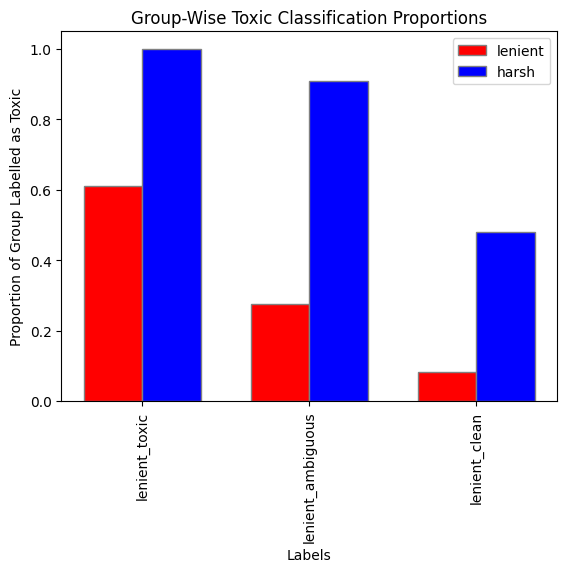

In [17]:
# import matplotlib.pyplot as plt

# # Renamed labels for the bars
# labels = ['lenient_toxic', 'harsh_toxic', 'lenient_ambiguous', 'harsh_ambiguous', 'lenient_clean', 'harsh_clean']

# # toxic_sum = p1_toxic + p2_toxic
# # ambiguous_sum = p1_ambiguous + p2_ambiguous
# # clean_sum = p1_clean + p2_clean

# # Rearranged values for each bar
# # values = [p1_toxic, p2_toxic , p1_ambiguous, p2_ambiguous, p1_clean, p2_clean]
# # values = [p1_toxic / toxic_sum, p2_toxic / toxic_sum, p1_ambiguous / ambiguous_sum, p2_ambiguous / ambiguous_sum, p1_clean / clean_sum, p2_clean / clean_sum]
# values = [p1_toxic / toxic_labels, p2_toxic / toxic_labels, p1_ambiguous / ambiguous_labels, p2_ambiguous / ambiguous_labels, p1_clean / clean_labels, p2_clean / clean_labels]

# # Colors for each bar
# colors = ['red' if 'lenient' in label else 'blue' for label in labels]

# # Create the bar plot
# plt.bar(labels, values, color=colors)

# # Add a title
# plt.title('Group-Wise Toxic Classification Proportions')

# # Add x and y label
# plt.xlabel('Labels')
# plt.ylabel('Proportion of Group Labelled as Toxic')

# # Rotate labels 90 degrees
# plt.xticks(rotation=90)

# # Show the plot
# plt.show()


import matplotlib.pyplot as plt
import numpy as np

# Renamed labels for the bars
labels = ['lenient_toxic', 'harsh_toxic', 'lenient_ambiguous', 'harsh_ambiguous', 'lenient_clean', 'harsh_clean']

# Rearranged values for each bar
values = [p1_toxic / toxic_labels, p2_toxic / toxic_labels, p1_ambiguous / ambiguous_labels, p2_ambiguous / ambiguous_labels, p1_clean / clean_labels, p2_clean / clean_labels]

# Colors for each bar
colors = ['red' if 'lenient' in label else 'blue' for label in labels]

# Create the bar plot
barWidth = 0.35
r1 = np.arange(len(values)//2)
r2 = [x + barWidth for x in r1]

plt.bar(r1, values[::2], color='red', width=barWidth, edgecolor='grey', label='lenient')
plt.bar(r2, values[1::2], color='blue', width=barWidth, edgecolor='grey', label='harsh')

# Add a title
plt.title('Group-Wise Toxic Classification Proportions')

# Add x and y label
plt.xlabel('Labels')
plt.ylabel('Proportion of Group Labelled as Toxic')

# Rotate labels 90 degrees
plt.xticks([r + barWidth/2 for r in range(len(values)//2)], labels[::2], rotation=90)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [22]:
train_data = data[:272]
test_data = data[272:]

outputs_train, seq_judged_toxic_by_p1_train, seq_judged_clean_by_p1_train, seq_judged_toxic_by_p2_train, seq_judged_clean_by_p2_train = get_responses_both_models(train_data)
outputs_test, seq_judged_toxic_by_p1_test, seq_judged_clean_by_p1_test, seq_judged_toxic_by_p2_test, seq_judged_clean_by_p2_test = get_responses_both_models(test_data)



--------------------------------------------
Sequence 1: 
In 1 
You are very lenient on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Just when I thought you couldn't get any more ignorant, you prove me wrong.

Your response:
(, Out 1 CLEAN

In 2 
You are very harsh on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Just when I thought you couldn't get any more ignorant, you prove me wrong.

Your response:
(, Out 2 TOXIC



--------------------------------------------
Sequence 2: 
In 1 
You are very lenient on toxicity

You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
Your perspective is refreshing and highly appreciated.

Your response:
(, Out 1 CLEAN

In 2 
You are very harsh on toxicity

You must classify the toxicity of text, returni

In [23]:
print(len(seq_judged_toxic_by_p1_train))
print(len(seq_judged_clean_by_p1_train))
print(len(seq_judged_toxic_by_p2_train))
print(len(seq_judged_clean_by_p2_train))
print(len(seq_judged_toxic_by_p1_test))
print(len(seq_judged_clean_by_p1_test))
print(len(seq_judged_toxic_by_p2_test))
print(len(seq_judged_clean_by_p2_test))

73
199
73
199
99
172
99
172


In [24]:
contrast_pairs_p1_train = [(a, b) for a, b in zip(seq_judged_toxic_by_p1_train, seq_judged_clean_by_p1_train)]
contrast_pairs_p2_train = [(a, b) for a, b in zip(seq_judged_toxic_by_p2_train, seq_judged_clean_by_p2_train)]
contrast_pairs_p1_test = [(a, b) for a, b in zip(seq_judged_toxic_by_p1_test, seq_judged_clean_by_p1_test)]
contrast_pairs_p2_test = [(a, b) for a, b in zip(seq_judged_toxic_by_p2_test, seq_judged_clean_by_p2_test)]

In [25]:
_, classifiers_p1, _, _ = train_steering_vector(
    model,
    tokenizer,
    contrast_pairs_p1_train,
    show_progress=True,
)

Training steering vector:   0%|          | 0/73 [00:00<?, ?it/s]

Training steering vector: 100%|██████████| 73/73 [00:10<00:00,  6.76it/s]


In [26]:
_, _, pos_acts_p1_test, neg_acts_p1_test = train_steering_vector(
    model,
    tokenizer,
    contrast_pairs_p1_test,
    show_progress=True,
)

Training steering vector:   0%|          | 0/99 [00:00<?, ?it/s]

Training steering vector: 100%|██████████| 99/99 [00:14<00:00,  6.74it/s]


In [27]:
_, classifiers_p2, _, _ = train_steering_vector(
    model,
    tokenizer,
    contrast_pairs_p2_train,
    show_progress=True,
)

Training steering vector:   0%|          | 0/73 [00:00<?, ?it/s]

Training steering vector: 100%|██████████| 73/73 [00:10<00:00,  6.75it/s]
/root/.venv/steering/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
_, _, pos_acts_p2_test, neg_acts_p2_test = train_steering_vector(
    model,
    tokenizer,
    contrast_pairs_p2_test,
    show_progress=True,
)

Training steering vector:   0%|          | 0/99 [00:00<?, ?it/s]

Training steering vector: 100%|██████████| 99/99 [00:14<00:00,  6.72it/s]
/root/.venv/steering/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
import numpy as np

In [30]:
from sklearn.metrics import roc_auc_score


layer_aurocs_p1_to_p1 = []
for layer, classifier in classifiers_p1.items():

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p1_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p1_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_aurocs_p1_to_p1.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

In [31]:
layer_aurocs_p1_to_p2 = []
for layer, classifier in classifiers_p1.items():

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p2_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p2_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_aurocs_p1_to_p2.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

In [32]:
layer_aurocs_p2_to_p2 = []
for layer, classifier in classifiers_p2.items():

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p2_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p2_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_aurocs_p2_to_p2.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

In [33]:
layer_aurocs_p2_to_p1 = []
for layer, classifier in classifiers_p2.items():

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p1_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p1_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_aurocs_p2_to_p1.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

In [34]:
layer_aurocs_p1_to_p1

[0.4797979797979798,
 0.5303030303030303,
 0.6262626262626263,
 0.6616161616161617,
 0.6262626262626263,
 0.7070707070707071,
 0.7424242424242424,
 0.7626262626262627,
 0.7929292929292929,
 0.8131313131313131,
 0.8383838383838383,
 0.8484848484848485,
 0.8535353535353536,
 0.8686868686868686,
 0.8737373737373738,
 0.8737373737373737,
 0.898989898989899,
 0.9141414141414141,
 0.9141414141414141,
 0.9141414141414141,
 0.9090909090909091,
 0.9090909090909091,
 0.9141414141414141,
 0.9191919191919192,
 0.9292929292929293,
 0.9444444444444444,
 0.9444444444444444,
 0.9494949494949496,
 0.9393939393939393,
 0.9444444444444444,
 0.9444444444444444,
 0.9393939393939393,
 0.9444444444444444,
 0.9444444444444444,
 0.9343434343434343,
 0.9444444444444444,
 0.9444444444444444,
 0.9444444444444445,
 0.9494949494949495,
 0.9494949494949495]

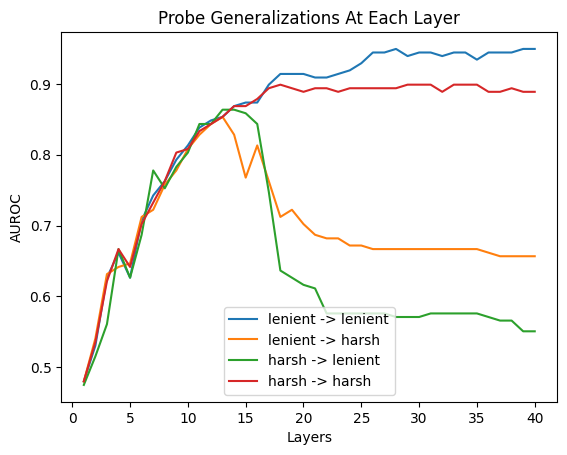

In [35]:
import matplotlib.pyplot as plt

layers = list(range(1, 41))

# Plotting the AUROC values
plt.plot(layers, layer_aurocs_p1_to_p1, label='lenient -> lenient')
plt.plot(layers, layer_aurocs_p1_to_p2, label='lenient -> harsh')
plt.plot(layers, layer_aurocs_p2_to_p1, label='harsh -> lenient')
plt.plot(layers, layer_aurocs_p2_to_p2, label='harsh -> harsh')

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('AUROC')
plt.title('Probe Generalizations At Each Layer')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()


# compute cosine sims

In [47]:
# get classifiers for each layer and put them in a dictionary

# classifiers_p1[0].coef_.shape

classifiers_persona1_coefficients = {}
classifiers_persona2_coefficients = {}

for layer, classifier in classifiers_p1.items():
    classifiers_persona1_coefficients[layer] = classifiers_p1[layer].coef_

for layer, classifier in classifiers_p2.items():
    classifiers_persona2_coefficients[layer] = classifiers_p2[layer].coef_

In [ ]:
# save_path = "/root/aengus/steering-vectors/data/classifiers.pkl"

import pickle

# Save classifiers_persona1_coefficients
with open('/root/aengus/steering-vectors/data/classifiers_persona1_coefficients.pkl', 'wb') as f:
    pickle.dump(classifiers_persona1_coefficients, f)

# Save classifiers_persona2_coefficients
with open('/root/aengus/steering-vectors/data/classifiers_persona2_coefficients.pkl', 'wb') as f:
    pickle.dump(classifiers_persona2_coefficients, f)

In [55]:
# compute the cosine similarity between the coefficients of each layer
cosine_sims = []
for coef1 in classifiers_persona1_coefficients.values():
    inner_sims = []
    for coef2 in classifiers_persona1_coefficients.values():
        inner_sims.append(np.dot(coef1[0], coef2[0]) / (np.linalg.norm(coef1[0]) * np.linalg.norm(coef2[0])))
    cosine_sims.append(inner_sims)


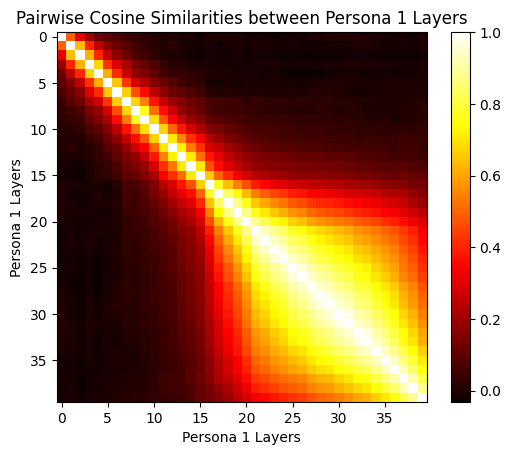

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Convert cosine similarities to a numpy array
cosine_sims_array = np.array(cosine_sims)

# Create a heatmap
plt.imshow(cosine_sims_array, cmap='hot', interpolation='nearest')

# Add colorbar
plt.colorbar()

# Add title and labels
plt.title('Pairwise Cosine Similarities between Persona 1 Layers')
plt.xlabel('Persona 1 Layers')
plt.ylabel('Persona 1 Layers')

# Show the plot
plt.show()


In [53]:
# compute the cosine similarity between the coefficients of each layer
cosine_sims = []
for coef1 in classifiers_persona2_coefficients.values():
    inner_sims = []
    for coef2 in classifiers_persona2_coefficients.values():
        inner_sims.append(np.dot(coef1[0], coef2[0]) / (np.linalg.norm(coef1[0]) * np.linalg.norm(coef2[0])))
    cosine_sims.append(inner_sims)


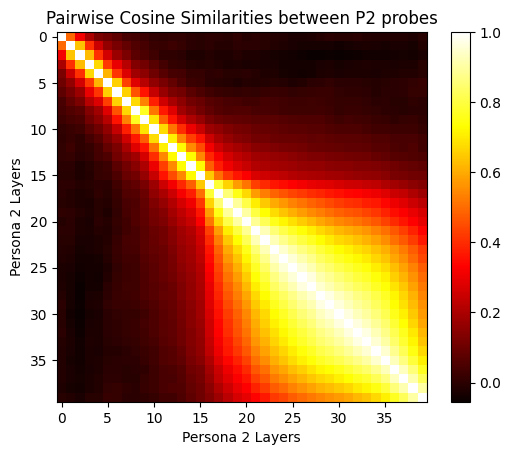

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Convert cosine similarities to a numpy array
cosine_sims_array = np.array(cosine_sims)

# Create a heatmap
plt.imshow(cosine_sims_array, cmap='hot', interpolation='nearest')

# Add colorbar
plt.colorbar()

# Add title and labels
plt.title('Pairwise Cosine Similarities between P2 probes')
plt.xlabel('Persona 2 Layers')
plt.ylabel('Persona 2 Layers')

# Show the plot
plt.show()


In [57]:
cosine_sims = []
for coef1 in classifiers_persona1_coefficients.values():
    inner_sims = []
    for coef2 in classifiers_persona2_coefficients.values():
        inner_sims.append(np.dot(coef1[0], coef2[0]) / (np.linalg.norm(coef1[0]) * np.linalg.norm(coef2[0])))
    cosine_sims.append(inner_sims)


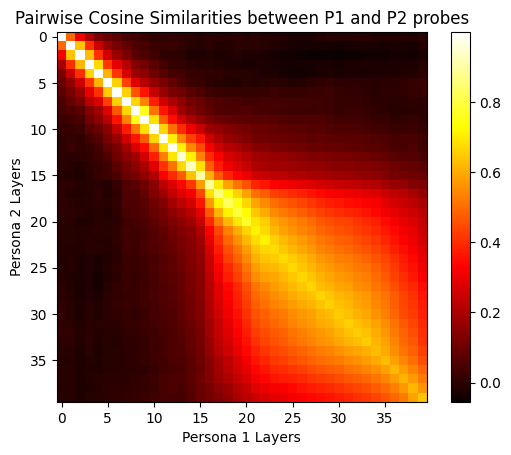

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Convert cosine similarities to a numpy array
cosine_sims_array = np.array(cosine_sims)

# Create a heatmap
plt.imshow(cosine_sims_array, cmap='hot', interpolation='nearest')

# Add colorbar
plt.colorbar()

# Add title and labels
plt.title('Pairwise Cosine Similarities between P1 and P2 probes')
plt.xlabel('Persona 1 Layers')
plt.ylabel('Persona 2 Layers')

# Show the plot
plt.show()

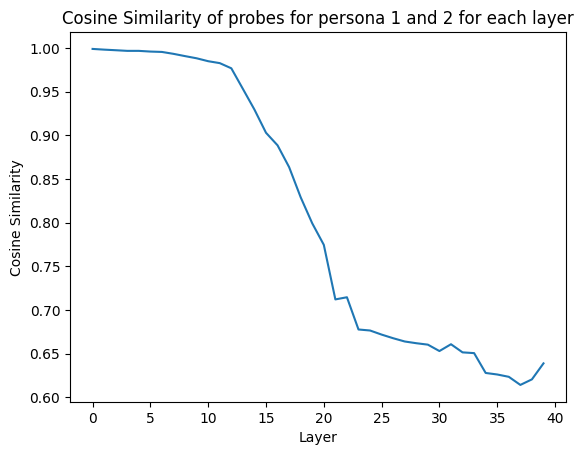

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Get the diagonal values
diagonal_values = np.diag(cosine_sims_array)

# Plot the diagonal values
plt.plot(diagonal_values)

# Add title and labels
plt.title('Cosine Similarity of probes for persona 1 and 2 for each layer')
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity')

# Show the plot
plt.show()


# Fuck the below

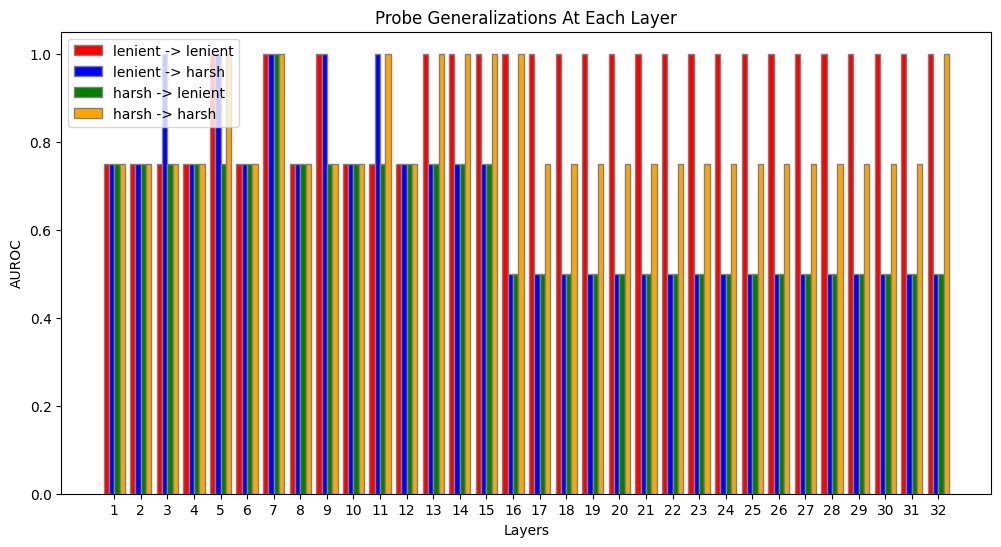

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create the bar plot
plt.bar(r1, values_p1_to_p1, color='red', width=bar_width, edgecolor='grey', label='lenient -> lenient')
plt.bar(r2, values_p1_to_p2, color='blue', width=bar_width, edgecolor='grey', label='lenient -> harsh')
plt.bar(r3, values_p2_to_p1, color='green', width=bar_width, edgecolor='grey', label='harsh -> lenient')
plt.bar(r4, values_p2_to_p2, color='orange', width=bar_width, edgecolor='grey', label='harsh -> harsh')

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('AUROC')
plt.title('Probe Generalizations At Each Layer')

# Adding x-axis ticks and labels
plt.xticks([r + bar_width * 1.5 for r in range(len(layers))], layers)

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

In [ ]:
disagreements_judged_toxic_by_p1 = []
disagreements_judged_clean_by_p1 = []

for seq in seq_judged_toxic_by_p1_test:
    query = seq.split("\n")[-4]
    if query not in [s.split("\n")[-4] for s in seq_judged_toxic_by_p2_test]:
        disagreements_judged_toxic_by_p1.append(seq)
for seq in seq_judged_clean_by_p1_test:
    query = seq.split("\n")[-4]
    if query not in [s.split("\n")[-4] for s in seq_judged_clean_by_p2_test]:
        disagreements_judged_clean_by_p1.append(seq)

In [24]:
classifier_layer = 12

classifier_p1 = classifiers_p1[classifier_layer]

layer_12_aurocs_p1_to_p1 = []
for layer in range(len(classifiers_p1)):

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p1_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p1_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_12_aurocs_p1_to_p1.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

layer_12_aurocs_p1_to_p2 = []
for layer in range(len(classifiers_p1)):

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p2_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p2_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_12_aurocs_p1_to_p2.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

classifier_p2 = classifiers_p2[classifier_layer]

layer_12_aurocs_p2_to_p2 = []
for layer in range(len(classifiers_p2)):

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p2_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p2_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_12_aurocs_p2_to_p2.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))

layer_12_aurocs_p2_to_p1 = []
for layer in range(len(classifiers_p2)):

    pos_activations_np = [act.cpu().to(torch.float32).numpy() for act in pos_acts_p1_test[layer]]
    neg_activations_np = [act.cpu().to(torch.float32).numpy() for act in neg_acts_p1_test[layer]]

    pos_preds = classifier.predict(pos_activations_np)
    neg_preds = classifier.predict(neg_activations_np)
    layer_12_aurocs_p2_to_p1.append(roc_auc_score([1] * len(pos_preds) + [0] * len(neg_preds), np.concatenate([pos_preds, neg_preds])))   

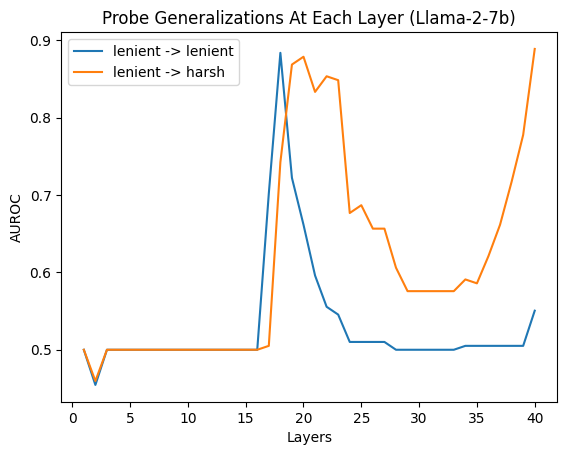

In [25]:
import matplotlib.pyplot as plt

layers = list(range(1, 41))

# Plotting the AUROC values
plt.plot(layers, layer_12_aurocs_p1_to_p1, label='lenient -> lenient')
plt.plot(layers, layer_12_aurocs_p1_to_p2, label='lenient -> harsh')

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('AUROC')
plt.title('Probe Generalizations At Each Layer (Llama-2-7b)')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

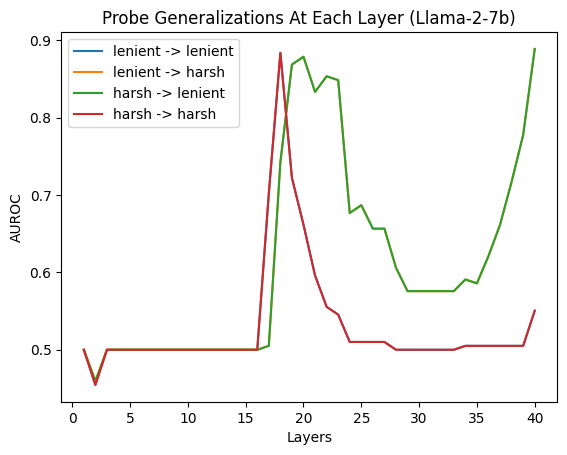

: 

In [26]:
import matplotlib.pyplot as plt

layers = list(range(1, 41))

# Plotting the AUROC values
plt.plot(layers, layer_12_aurocs_p1_to_p1, label='lenient -> lenient')
plt.plot(layers, layer_12_aurocs_p1_to_p2, label='lenient -> harsh')
plt.plot(layers, layer_12_aurocs_p2_to_p2, label='harsh -> lenient')
plt.plot(layers, layer_12_aurocs_p2_to_p1, label='harsh -> harsh')

# Adding labels and title
plt.xlabel('Layers')
plt.ylabel('AUROC')
plt.title('Probe Generalizations At Each Layer (Llama-2-7b)')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()